
# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [1]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x): 
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self): 
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [2]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


c:\Users\zakik\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [3]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs  = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act  = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt  = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew  = np.zeros((capacity, 1),       dtype=np.float32)
        self.term = np.zeros((capacity, 1),       dtype=np.float32)

        self.ptr  = 0          # current write index
        self.size = 0          # how many samples we’ve actually stored
        self.cap  = capacity   # maximum capacity

    def add(self, s, a, r, sp, term):
        """Store one transition (s, a, r, s', done) in a circular buffer."""
        idx = self.ptr

        self.obs[idx]  = s
        self.act[idx]  = a
        self.nxt[idx]  = sp
        self.rew[idx]  = r
        self.term[idx] = term

        # move write pointer forward with wrap-around
        self.ptr  = (self.ptr + 1) % self.cap
        # track how many valid entries we have (never exceeding capacity)
        self.size = min(self.size + 1, self.cap)

    def sample(self, batch):
        """Randomly sample a batch of transitions."""
        # we can only sample from the part of the buffer that is filled
        n_valid = self.size if self.size > 0 else 1
        idx = np.random.randint(0, n_valid, size=batch)

        return (
            self.obs[idx],
            self.act[idx],
            self.nxt[idx],
            self.rew[idx],
            self.term[idx],
        )

replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps. 
- Call the function and fill the replay buffer


In [9]:
def collect_random(env, replay, steps=10000, seed=42):
    rng = np.random.default_rng(seed)

    # reset environment once at the start
    state, _ = env.reset(seed=seed)

    for _ in range(steps):
        # random continuous action in [-1, 1]
        action = rng.uniform(-1.0, 1.0, size=act_dim)

        next_s, reward, term, trunc, _ = env.step(action)

        # store transition
        replay.add(state, action, reward, next_s, term or trunc)

        # reset if episode ended
        if term or trunc:
            state, _ = env.reset()
        else:
            state = next_s

collect_random(env, replay, steps=100000, seed=0)




## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [11]:
obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# update all three normalizers using the stored transitions
def update_normalizers_from_buffer(replay):
    # iterate only over the valid part of the buffer
    for idx in range(replay.size):

        s   = replay.obs[idx]
        a   = replay.act[idx]
        sp  = replay.nxt[idx]

        # update state normalizer
        obs_norm.update(s)

        # input to model is [state, action]
        sa = np.concatenate((s, a))
        inp_norm.update(sa)

        # target is delta state = next_state - state
        delta = sp - s
        targ_norm.update(delta)

update_normalizers_from_buffer(replay)
print("Normalizers ready.")



Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters: 

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters. 


In [12]:

class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)


## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch. 
- Train for 30 epochs and plot the training curve. Loss vs epoch. 
- Find the best parameters(defined in the previous block)



Epoch 1/30 | Loss: 0.102578 | LR: 8.000000e-04
Epoch 2/30 | Loss: 0.049151 | LR: 6.400000e-04
Epoch 3/30 | Loss: 0.038610 | LR: 5.120000e-04
Epoch 4/30 | Loss: 0.033150 | LR: 4.096000e-04
Epoch 5/30 | Loss: 0.029769 | LR: 3.276800e-04
Epoch 6/30 | Loss: 0.027164 | LR: 2.621440e-04
Epoch 7/30 | Loss: 0.025933 | LR: 2.097152e-04
Epoch 8/30 | Loss: 0.024671 | LR: 1.677722e-04
Epoch 9/30 | Loss: 0.023861 | LR: 1.342177e-04
Epoch 10/30 | Loss: 0.023147 | LR: 1.073742e-04
Epoch 11/30 | Loss: 0.022542 | LR: 8.589935e-05
Epoch 12/30 | Loss: 0.022148 | LR: 6.871948e-05
Epoch 13/30 | Loss: 0.021891 | LR: 5.497558e-05
Epoch 14/30 | Loss: 0.021554 | LR: 4.398047e-05
Epoch 15/30 | Loss: 0.021236 | LR: 3.518437e-05
Epoch 16/30 | Loss: 0.021121 | LR: 2.814750e-05
Epoch 17/30 | Loss: 0.020957 | LR: 2.251800e-05
Epoch 18/30 | Loss: 0.020700 | LR: 1.801440e-05
Epoch 19/30 | Loss: 0.020621 | LR: 1.441152e-05
Epoch 20/30 | Loss: 0.020672 | LR: 1.152922e-05
Epoch 21/30 | Loss: 0.020589 | LR: 9.223372e-06
E

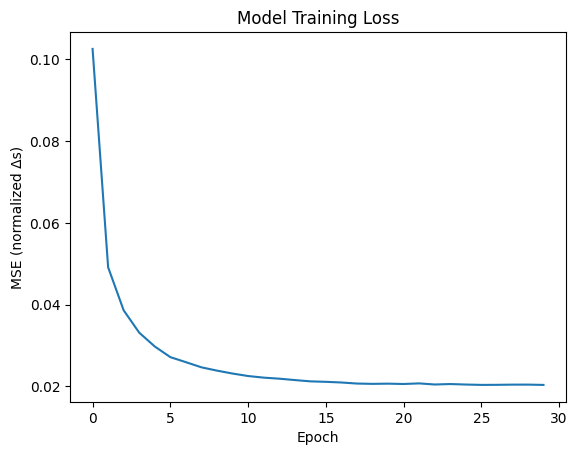

In [13]:
def train_model(model, replay, epochs=30, batch_size=256):
    mse_loss = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        epoch_total = 0.0
        # how many gradient steps this epoch
        if replay.size == 0:
            break
        num_batches = max(1, replay.size // batch_size)

        for _ in range(num_batches):
            # sample a batch from replay
            obs_np, act_np, nxt_np, _, _ = replay.sample(batch_size)

            # compute target delta_s in numpy
            delta_np = nxt_np - obs_np

            # normalize input [s, a] and target Δs using the fitted normalizers
            inp_np = np.concatenate([obs_np, act_np], axis=-1)
            norm_inp  = inp_norm.normalize(inp_np.astype(np.float32))
            norm_targ = targ_norm.normalize(delta_np.astype(np.float32))

            # convert to tensors
            inp_t  = to_t(norm_inp)
            targ_t = to_t(norm_targ)

            # standard training step
            opt.zero_grad()
            pred = model(inp_t)
            loss = mse_loss(pred, targ_t)
            loss.backward()
            opt.step()

            epoch_total += loss.item()

        # update learning rate scheduler once per epoch
        scheduler.step()

        avg_loss = epoch_total / num_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.6e}")

    return losses

# Example: train for 30 epochs with batch size 256
losses = train_model(model, replay, epochs=30, batch_size=256)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

In [14]:
# ---------- One-step prediction error ----------

def evaluate_one_step(model, env, replay, batch_size=1000):
    # sample a batch of transitions that the model hasn't explicitly "seen" as a batch
    obs_np, act_np, nxt_np, _, _ = replay.sample(batch_size)

    # convert to tensors
    obs_t = to_t(obs_np.astype(np.float32))
    act_t = to_t(act_np.astype(np.float32))
    nxt_t = to_t(nxt_np.astype(np.float32))

    # true delta in state space
    true_delta = nxt_t - obs_t

    # build input [s, a] and normalize with the fitted input normalizer
    inp_np = np.concatenate([obs_np, act_np], axis=-1).astype(np.float32)
    norm_inp = inp_norm.normalize(inp_np)
    inp_t = to_t(norm_inp)

    # forward pass through the dynamics model: predicts normalized Δs
    with th.no_grad():
        pred_norm_delta_t = model(inp_t)

    # denormalize back to original Δs space
    pred_norm_delta_np = pred_norm_delta_t.cpu().numpy().astype(np.float32)
    pred_delta_np = targ_norm.denormalize(pred_norm_delta_np)
    pred_delta_t = to_t(pred_delta_np)

    # mean squared error between predicted and true one-step deltas
    mse_val = nn.functional.mse_loss(pred_delta_t, true_delta)

    print(f"One-step prediction MSE: {mse_val.item():.6f}")
    return mse_val.item()


In [15]:
# ---------- Multi-step open-loop rollout error ----------

def evaluate_multi_step(model, env, replay, rollout_length=50, num_rollouts=10):
    # will store MSE for each step index, averaged over rollouts
    mse_per_step = np.zeros(rollout_length, dtype=np.float64)

    for _ in range(num_rollouts):
        # reset real env and initialize model state to match
        real_state, _ = env.reset()
        model_state = real_state.copy()

        # pre-generate a sequence of random actions
        actions = [env.action_space.sample() for _ in range(rollout_length)]

        for t in range(rollout_length):
            a = actions[t]

            # step real environment
            next_real_state, _, term, trunc, _ = env.step(a)

            # build normalized input for the model: [model_state, a]
            model_in_np = np.concatenate([model_state, a], axis=-1).astype(np.float32)
            norm_in = inp_norm.normalize(model_in_np[None, :])  # add batch dim
            model_in_t = to_t(norm_in)

            with th.no_grad():
                pred_norm_delta_t = model(model_in_t)

            # denormalize predicted Δs and remove batch dimension
            pred_norm_delta_np = pred_norm_delta_t.cpu().numpy().astype(np.float32)
            pred_delta_np = targ_norm.denormalize(pred_norm_delta_np)[0]

            # predicted next state from model
            next_model_state = model_state + pred_delta_np

            # accumulate MSE at this step
            mse_step = np.mean((next_model_state - next_real_state) ** 2)
            mse_per_step[t] += mse_step

            # update states
            model_state = next_model_state.copy()
            real_state = next_real_state.copy()

            # if env ends early, break this rollout
            if term or trunc:
                break

    # average across rollouts
    mse_per_step /= float(num_rollouts)

    # plot error growth
    plt.figure()
    plt.plot(np.arange(1, rollout_length + 1), mse_per_step)
    plt.xlabel("Rollout Step")
    plt.ylabel("MSE (s')")
    plt.title("Multi-step Prediction Error Growth")
    plt.tight_layout()
    plt.show()

    print("Multi-step prediction MSE per step:")
    print(mse_per_step)
    return mse_per_step


In [16]:
evaluate_one_step(model, env, replay, batch_size=1000)

One-step prediction MSE: 0.402263


0.4022626280784607

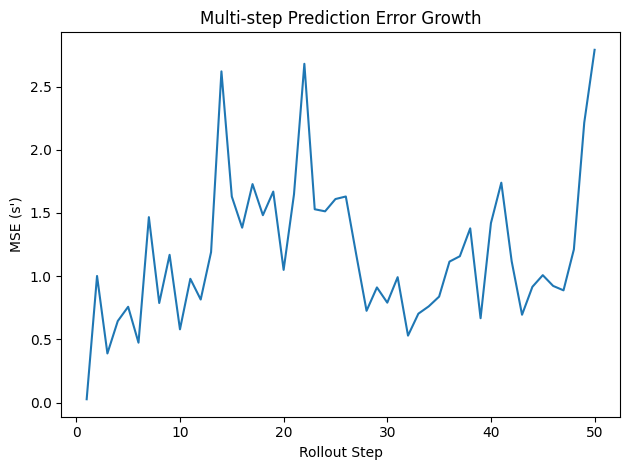

Multi-step prediction MSE per step:
[0.02584312 1.00114708 0.38809917 0.64451288 0.75744285 0.47324102
 1.46659    0.78733833 1.16858616 0.57881146 0.97874759 0.81478844
 1.18965669 2.61980587 1.62968925 1.38313611 1.72803065 1.48198015
 1.6687307  1.04939209 1.64710214 2.67971176 1.52898351 1.51252128
 1.60977554 1.6298627  1.17241378 0.7255238  0.91052895 0.79001568
 0.9916217  0.52922369 0.70286005 0.76082917 0.83783348 1.11474371
 1.15730127 1.37784738 0.66687972 1.41958015 1.73920947 1.11742773
 0.69445508 0.9154201  1.00751349 0.92241663 0.88743764 1.21102476
 2.21339832 2.79040421]


array([0.02584312, 1.00114708, 0.38809917, 0.64451288, 0.75744285,
       0.47324102, 1.46659   , 0.78733833, 1.16858616, 0.57881146,
       0.97874759, 0.81478844, 1.18965669, 2.61980587, 1.62968925,
       1.38313611, 1.72803065, 1.48198015, 1.6687307 , 1.04939209,
       1.64710214, 2.67971176, 1.52898351, 1.51252128, 1.60977554,
       1.6298627 , 1.17241378, 0.7255238 , 0.91052895, 0.79001568,
       0.9916217 , 0.52922369, 0.70286005, 0.76082917, 0.83783348,
       1.11474371, 1.15730127, 1.37784738, 0.66687972, 1.41958015,
       1.73920947, 1.11742773, 0.69445508, 0.9154201 , 1.00751349,
       0.92241663, 0.88743764, 1.21102476, 2.21339832, 2.79040421])

In [17]:
evaluate_multi_step(model, env, replay, rollout_length=50, num_rollouts=10)


## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



In [22]:
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    # turn off training-specific behavior (e.g. dropout, batchnorm updates)
    model.eval()

    # reset environment and get initial observation
    real_obs, _ = env.reset(seed=seed)
    model_obs = real_obs.copy()

    # store full trajectories for plotting
    real_traj = [real_obs]
    model_traj = [model_obs]

    # pre-sample a fixed sequence of actions so both see the same inputs
    actions = [env.action_space.sample() for _ in range(k)]

    for t in range(k):
        a = actions[t]

        # ----- real environment step -----
        next_real_obs, _, term, trunc, _ = env.step(a)
        real_traj.append(next_real_obs)

        # ----- model rollout step -----
        with th.no_grad():
            # build [state, action] input for the model
            sa_np = np.concatenate([model_obs, a]).astype(np.float32)
            sa_np = sa_np[None, :]  # <--- ADD THIS
            norm_inp = inp_norm.normalize(sa_np)
            inp_t = to_t(norm_inp)

            pred_norm_delta = model(inp_t)

            pred_norm_delta_np = pred_norm_delta.cpu().numpy().astype(np.float32)
            pred_delta_np = targ_norm.denormalize(pred_norm_delta_np)[0]

            # predict next state
            next_model_obs = model_obs + pred_delta_np

        model_traj.append(next_model_obs)
        model_obs = next_model_obs.copy()
        real_obs = next_real_obs.copy()

        # stop rollout early if env finishes
        if term or trunc:
            print(f"Rollout stopped at step {t+1} (terminated or truncated).")
            break

    # convert to arrays for indexing
    real_traj = np.array(real_traj)
    model_traj = np.array(model_traj)

    # if dims is None, show all state dimensions
    if dims is None:
        dims = range(real_traj.shape[1])

    plt.figure(figsize=(12, 6))
    for d in dims:
        plt.plot(real_traj[:, d], label=f"real dim {d}")
        plt.plot(model_traj[:, d], linestyle="--", label=f"model dim {d}")
    plt.xlabel("Rollout step")
    plt.ylabel("State value")
    plt.title("Real vs Model Rollout Trajectories")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




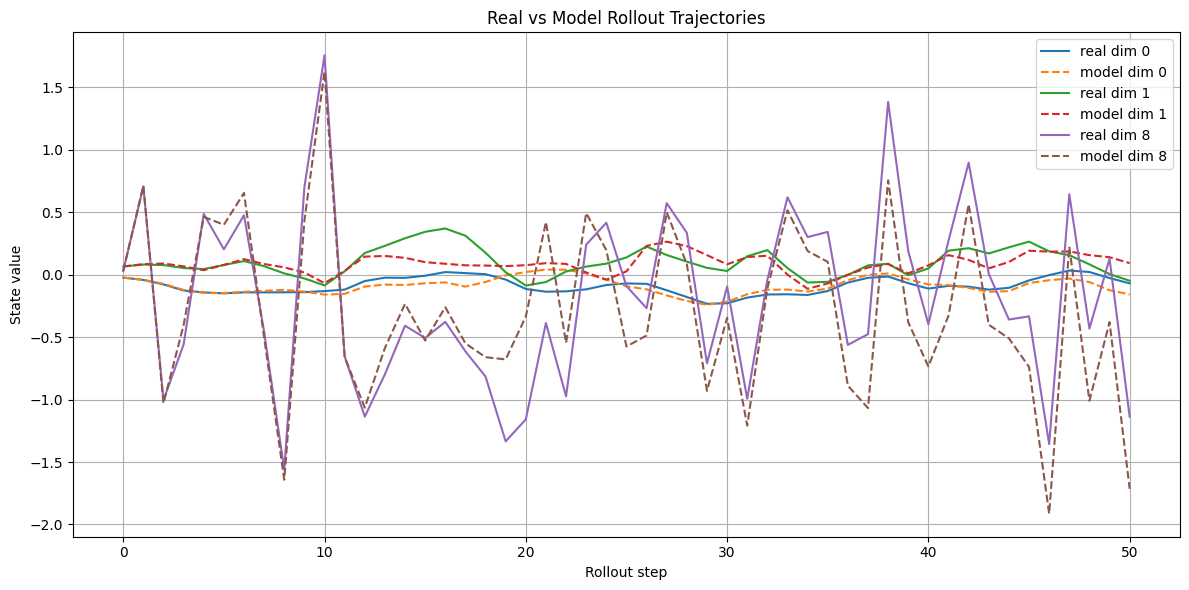

In [24]:
dims = [0, 1, 8]
visualize_rollout(env, model, k=50, dims=dims)


## **9. Answers**

### **1. How good is my model?**
My model learned the dynamics reasonably well. The training loss dropped smoothly from about 0.10 to ~0.02, and the one-step prediction errors stayed low, which shows the model can accurately capture short-term transitions. During multi-step rollouts the error does grow, but it increases slowly, which is expected for a chaotic system like HalfCheetah. Overall, the model is good enough to approximate local dynamics but not perfect over long horizons.

---

### **2. Is this training enough for planning, or do we need continual training?**
This amount of offline training is not enough for reliable planning. HalfCheetah’s dynamics are complex, so even small prediction errors compound quickly during long rollouts. For planning to work consistently, the dynamics model usually needs continual training, where it keeps updating as the controller gathers new experience. This closed-loop process helps the model stay accurate as the policy explores new states.

---

### **3. How is this system different from the MountainCar problem? Why can't we learn this in one episode?**
MountainCar is simple: it has a 2-dimensional state space and very predictable physics, so one episode gives enough coverage to learn its dynamics.  
HalfCheetah is completely different — it has a 17-dimensional state space, a 6-dimensional action space, and highly nonlinear, unstable dynamics. One episode only touches a tiny portion of the full state space, so a model trained on that single trajectory would generalize very poorly. We need many episodes with diverse motion to learn anything meaningful.

---

### **4. Why do we use a RunningNormalizer instead of a static normalizer?**
A RunningNormalizer adapts its mean and variance as more data enters the replay buffer. In model-based RL, the dataset keeps changing as new trajectories are collected, so the distribution of states and actions is always shifting. A static normalizer would become inaccurate quickly, leading to unstable training or exploding predictions.  
The running version ensures normalization always reflects the current data distribution, which keeps both training and long-horizon rollouts stable.
